In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv

## Section 1: Model Comparison

In [2]:
for m in range(3):
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', '1pl', f'1pl_m{m+1}_ppc.csv'))
    if np.any(ppc.k_u > 0.5): print(f'[m{m}] WARNING: k-hat measures above 0.5.')
        
    ## Model comparison.
    louo = ppc.louo.sum()
    loco = ppc.groupby('subject').loco.mean().sum()
    pwaic_u = ppc.pwaic_u.sum()
    pwaic_c = ppc.groupby('subject').pwaic_c.mean().sum()
    
    print('m%s:  %0.3f | %0.3f | %0.3f | %0.3f' %(m+1, louo, loco, pwaic_u, pwaic_c))

m1:  -7229.261 | -7179.556 | 639.913 | 89.494
m2:  -7016.044 | -6960.038 | 669.168 | 130.654
m3:  -6926.417 | -6865.864 | 704.771 | 173.098


In [3]:
for a, b in [[1,2],[1,3],[2,3]]:
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', '1pl', f'1pl_m{a}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', '1pl', f'1pl_m{b}_ppc.csv'))
    
    arr = df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean()
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'm{b} - m{a}: %0.3f (%0.3f)' %(mu, se))

m2 - m1: 219.517 (19.907)
m3 - m1: 313.692 (23.629)
m3 - m2: 94.174 (13.456)


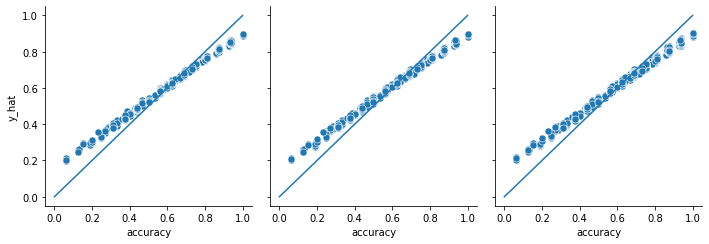

In [4]:
fig, axes = plt.subplots(1,3,figsize=(10,3.5),sharex=True,sharey=True)
agg = {'accuracy':'mean', 'y_hat':'mean'}

for m, ax in enumerate(axes.flatten()):
    
    ppc = read_csv(os.path.join('stan_results', '1pl', f'1pl_m{m+1}_ppc.csv'))
    gb = ppc.groupby('subject').agg(agg)
    
    sns.scatterplot(x='accuracy', y='y_hat', data=gb, s=50, ax=ax)
    ax.plot([0,1],[0,1])
    
sns.despine()
plt.tight_layout()

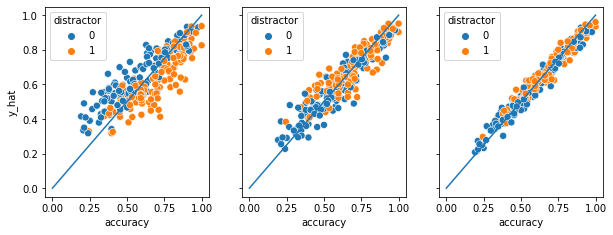

In [5]:
fig, axes = plt.subplots(1,3,figsize=(10,3.5),sharex=True,sharey=True)
agg = {'accuracy':'mean', 'y_hat':'mean'}

for m, ax in enumerate(axes.flatten()):
    
    ppc = read_csv(os.path.join('stan_results', '1pl', f'1pl_m{m+1}_ppc.csv'))
    gb = ppc.groupby(['item','distractor','test_form']).agg(agg).reset_index()
    gb['delta'] = gb['accuracy'] - gb['y_hat']
    
    sns.scatterplot(x='accuracy', y='y_hat', data=gb, hue='distractor', s=50, ax=ax)
    ax.plot([0,1],[0,1])

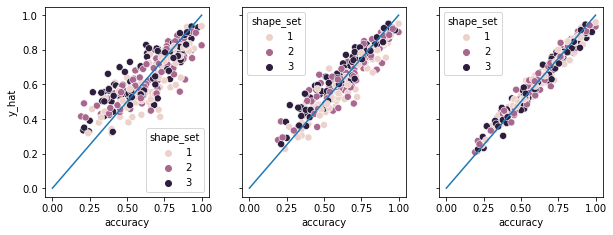

In [6]:
fig, axes = plt.subplots(1,3,figsize=(10,3.5),sharex=True,sharey=True)
agg = {'accuracy':'mean', 'y_hat':'mean'}

for m, ax in enumerate(axes.flatten()):
    
    ppc = read_csv(os.path.join('stan_results', '1pl', f'1pl_m{m+1}_ppc.csv'))
    gb = ppc.groupby(['item','distractor','shape_set']).agg(agg).reset_index()
    gb['delta'] = gb['accuracy'] - gb['y_hat']
    
    sns.scatterplot(x='accuracy', y='y_hat', data=gb, hue='shape_set', s=50, ax=ax)
    ax.plot([0,1],[0,1])

In [101]:
from pandas import DataFrame
from scipy.stats import pearsonr, spearmanr

df = read_csv('stan_results/1pl/1pl_m3_summary.tsv', sep='\t', index_col=0)
beta = df.T.filter(regex='beta\[').T['Mean'].values.reshape(4,-1).T
beta = DataFrame(beta)

          0         1         2
0  1.000000  0.732902  0.973446
1  0.732902  1.000000  0.917375
2  0.973446  0.917375  1.000000


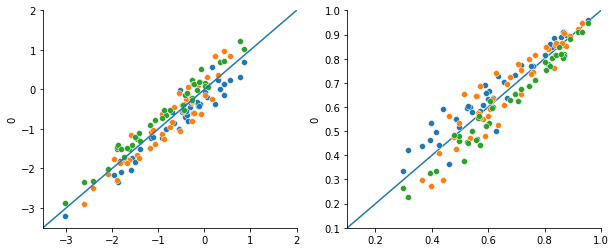

In [106]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

b = DataFrame(np.column_stack([
    beta.values @ [1,0.5,1,0],
    beta.values @ [1,0.5,0,0],
    beta.values @ [1,0.5,0,1]
]))
b = b * np.where(ppc.pivot_table('accuracy','item','shape_set').notnull(), 1, np.nan)
print(b.corr())

fig, axes = plt.subplots(1,2,figsize=(10,4))

for i in range(3):
    sns.scatterplot(x=b.mean(axis=1), y=b[i], ax=axes[0])
    sns.scatterplot(x=inv_logit(-b.mean(axis=1)), y=inv_logit(-b[i]), ax=axes[1])
    
axes[0].plot([-3.5,2],[-3.5,2])
axes[0].set(xlim=(-3.5,2), ylim=(-3.5,2))
    
axes[1].plot([0,1],[0,1],zorder=-1)
axes[1].set(xlim=(0.1,1.0), ylim=(0.1,1.0))
    
sns.despine()

          0         1
0  1.000000  0.908287
1  0.908287  1.000000


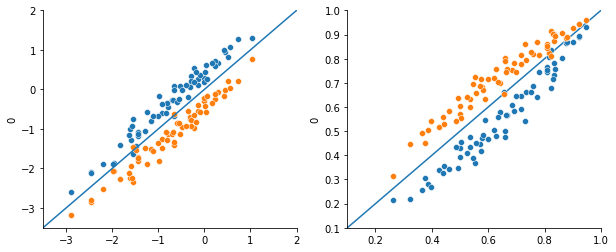

In [104]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

mask = np.where(ppc.pivot_table('trial','item','shape_set').notnull(), 1, np.nan)
b1 = np.column_stack([beta @ [1,0,0,0], beta @ [1,0,1,0], beta @ [1,0,0,1]])
b2 = np.column_stack([beta @ [1,1,0,0], beta @ [1,1,1,0], beta @ [1,1,0,1]])
b = DataFrame(np.column_stack([np.nansum(b1 * mask, axis=1), np.nansum(b2 * mask, axis=1)])) / 2

print(b.corr())
fig, axes = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    sns.scatterplot(x=b.mean(axis=1), y=b[i], ax=axes[0])
    sns.scatterplot(x=inv_logit(-b.mean(axis=1)), y=inv_logit(-b[i]), ax=axes[1])
    
axes[0].plot([-3.5,2],[-3.5,2])
axes[0].set(xlim=(-3.5,2), ylim=(-3.5,2))
    
axes[1].plot([0,1],[0,1],zorder=-1)
axes[1].set(xlim=(0.1,1.0), ylim=(0.1,1.0))
    
sns.despine()

<AxesSubplot:xlabel='x', ylabel='accuracy'>

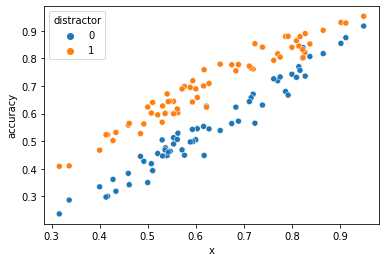

In [66]:
## Compute item accuracy by test form.
gb = ppc.pivot_table('y_hat', 'item', 'distractor')
gb['x'] = ppc.groupby('item').accuracy.mean()
gb = gb.melt(id_vars='x', value_name='accuracy')
gb['delta'] = gb['accuracy'] - gb['x']
sns.scatterplot(x='x', y='accuracy', hue='distractor', data=gb)

<AxesSubplot:xlabel='x', ylabel='accuracy'>

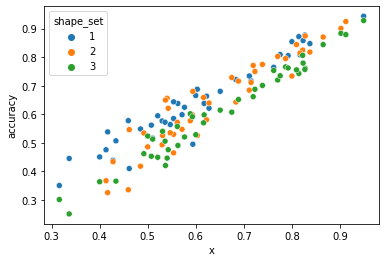

In [107]:
## Compute item accuracy by shape set.
gb = ppc.pivot_table('y_hat','item','shape_set')
gb['x'] = ppc.groupby('item').accuracy.mean()
gb = gb.melt(id_vars='x', value_name='accuracy')
gb['delta'] = gb['accuracy'] - gb['x']

palette = sns.color_palette(n_colors=3)
sns.scatterplot(x='x', y='accuracy', hue='shape_set', data=gb, palette=palette)

<AxesSubplot:xlabel='1', ylabel='3'>

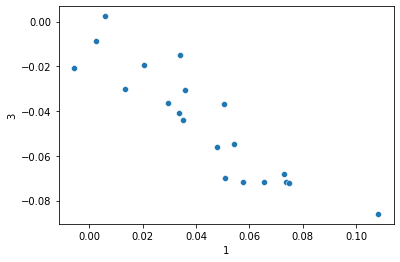

In [110]:
sns.scatterplot(x=1, y=3, data=gb.pivot_table('delta','x','shape_set'))

<AxesSubplot:xlabel='2', ylabel='3'>

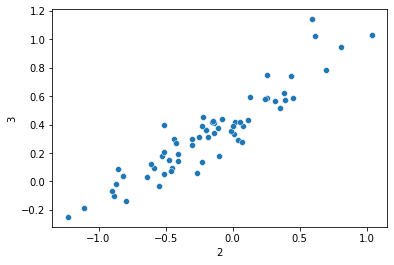

In [145]:
sns.scatterplot(x=beta[2], y=beta[3])

In [146]:
Corr = df.T.filter(regex='Corr').T['Mean'].values.reshape(4,4)
Corr

array([[ 1.   , -0.213, -0.29 , -0.182],
       [-0.213,  1.   , -0.368, -0.243],
       [-0.29 , -0.368,  1.   ,  0.776],
       [-0.182, -0.243,  0.776,  1.   ]])

array([[ 1.   , -0.213, -0.29 , -0.182],
       [-0.213,  1.   , -0.368, -0.243],
       [-0.29 , -0.368,  1.   ,  0.776],
       [-0.182, -0.243,  0.776,  1.   ]])

In [182]:
sigma = np.array([1.0, 0.6, 0.4])
Omega = np.array([[1,-0.25,-0.25], [-0.25,1,0.8], [-0.25,0.8,1.0]])
L = np.diag(sigma) @ np.linalg.cholesky(Omega)
arr = L @ np.random.normal(0, 1, (3, 100))

arr = np.column_stack([
    -0.2 + arr.T @ [1,1,0],
    0.0 + arr.T @ [1,0,0],
    0.3 + arr.T @ [1,0,1],
])

<AxesSubplot:>

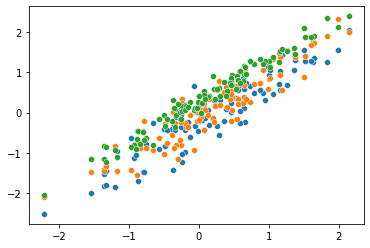

In [184]:
sns.scatterplot(x=arr.mean(axis=1), y=arr[:,0])
sns.scatterplot(x=arr.mean(axis=1), y=arr[:,1])
sns.scatterplot(x=arr.mean(axis=1), y=arr[:,2])

In [189]:
beta_pr.corr()

,0,1,2,3
0,1.000000,0.042008,0.190098,0.215701
1,0.042008,1.000000,-0.139059,0.024193
2,0.190098,-0.139059,1.000000,0.336969
3,0.215701,0.024193,0.336969,1.000000


In [192]:
test = read_csv('stan_results/2pl_fixed_summary.tsv', sep='\t', index_col=0)

In [196]:
test.T.filter(regex='Corr').T['Mean'].values.reshape(4,4)

array([[ 1.    ,  0.846 ,  0.0298, -0.225 ],
       [ 0.846 ,  1.    ,  0.11  , -0.118 ],
       [ 0.0298,  0.11  ,  1.    ,  0.0977],
       [-0.225 , -0.118 ,  0.0977,  1.    ]])